In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib as Path
import matplotlib.pyplot as plt
import urllib.request as request
import albumentations as albu
import cv2

In [2]:
ROOT = '.'
os.chdir(ROOT)

In [7]:
import tarfile
data_URL = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

# create a directory
def create_dirs(dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory created")
    
ROOT_DATA_DIR = "dataset"
create_dirs(ROOT_DATA_DIR)

data_tar_gz_file = "cifar-100-python.tar.gz"
data_tar_gz_path = os.path.join(ROOT_DATA_DIR, data_tar_gz_file)

if not os.path.isfile(data_tar_gz_path):
    print("downloading data...")
    filename, headers = request.urlretrieve(data_URL, data_tar_gz_path)
    print(f"filename: {filename} created with info \n{headers}")
    # !tar -xvf data_tar_gz_path
    # open file
    file = tarfile.open(data_tar_gz_path)
      
    # extracting file
    file.extractall(ROOT_DATA_DIR)
      
    file.close()    
else:
    print(f"file is already present by manual download. Now extracting programaticaly.")
    file = tarfile.open(data_tar_gz_path)
      
    # extracting file
    file.extractall(ROOT_DATA_DIR)    

dataset directory created
file is already present by manual download. Now extracting programaticaly.


###function to read files present in the Python version of the dataset

In [8]:
import pickle
def unpickle(file):
  with open(file, 'rb') as fo:
    myDict = pickle.load(fo, encoding='latin1')
  return myDict

In [9]:
DATA_FOLDER = os.path.join(ROOT, ROOT_DATA_DIR, 'cifar-100-python')
os.chdir(DATA_FOLDER)

trainData = unpickle('train')

# print type of item in each trainData-file
for item in trainData:
  print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


### There are 50,000 images in the training dataset and each image is a 3 channel 32 × 32 pixel image (32 × 32 × 3 = 3072).

In [10]:
print(len(trainData['data']))
print(trainData['data'].shape)
print(len(trainData['fine_labels']))

50000
(50000, 3072)
50000


In [11]:
# There are 100 different fine labels for the images ranging from 0 to 99.
print(np.unique(trainData['fine_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [12]:
print(len(trainData['coarse_labels']))
# There are 20 different coarse labels for the images ranging from 0 to 19.
print(np.unique(trainData['coarse_labels']))

50000
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [13]:
print(trainData['batch_label']) #we have only one batch

training batch 1 of 1


In [14]:
testData = unpickle('test')
metaData = unpickle('meta')

In [15]:
#metaData
print("Fine labels:", metaData['fine_label_names'], "\n")
print("Coarse labels:", metaData['coarse_label_names'])

Fine labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

In [16]:
import pandas as pd
#storing coarse labels along with its number code in a dataframe
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
category

,SuperClass
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


In [17]:
#storing fine labels along with its number code in a dataframe
subCategory = pd.DataFrame(metaData['fine_label_names'], columns =['SubClass'])
subCategory

,SubClass
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


In [18]:
X_train = trainData['data']
print(len(X_train))
print(X_train.shape)

50000
(50000, 3072)


### Image Transformation for Tensorflow (Keras) and Convolutional Neural Networks


In [19]:
#4D array input for building the CNN model using Keras

X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1) #The i’th axis of the returned array will correspond to the axis numbered axes[i] of the input. 
X_train.shape

(50000, 32, 32, 3)

### Exploring the Images in the Dataset

In [20]:
#generating a random number to display a random image from the dataset along with the label's number and name
from pylab import rcParams
rcParams['figure.figsize'] = 2,2


image number selected: 49784
shape of image : (32, 32, 3)
image category number : 11
image category name : Large_omnivores_and_herbivores
image sub-category number : 15
image sub-category name : Camel


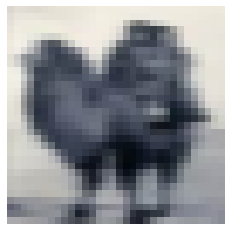

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
imageId = np.random.randint(0, len(X_train))
plt.imshow(X_train[imageId])
plt.axis('off')

print("image number selected: {}".format(imageId))
print("shape of image : {}".format(X_train[imageId].shape))
print("image category number : {}".format(trainData['coarse_labels'][imageId]))
print("image category name : {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize())) # Captilize only the first letter in pandas string
print("image sub-category number : {}".format(trainData['fine_labels'][imageId]))
print("image sub-category name : {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize())) # Captilize only the first letter in pandas string

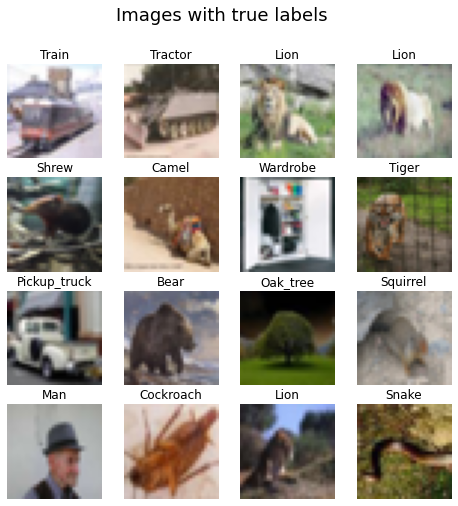

In [22]:
#16 random images to display at a time along with their true labels
rcParams['figure.figsize'] = 8,8

num_row = 4
num_col = 4

#to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row*num_col)

fig, axes = plt.subplots(num_row, num_col)
plt.suptitle('Images with true labels', fontsize=18)

for i in range(0, num_row):
  for j in range(0, num_col):
    k = (i*num_col)+j
    axes[i,j].imshow(X_train[imageId[k]])
    axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())
    axes[i,j].axis('off')


### Data Pre-processing

In [23]:
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [24]:
y_train = trainData['fine_labels']
#y_train

y_test = testData['fine_labels']
# y_test

### Converting class vectors to binary class matrices

1.   List item
2.   List item

In [25]:
from tensorflow.keras.utils import to_categorical

n_classes = 100

y_train = to_categorical(y_train, n_classes)
#y_train

y_test = to_categorical(y_test, n_classes)
# y_test
# y_test.shape

### Splitting the training dataset into training and validation datasets

In [26]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#using stratified shuffle split to preserve the percentage of samples in each of the 100 classes
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)
for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Shape of training samples: ", X_train_data.shape)
print("Shape of validation samples: ", X_val_data.shape)  
print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Shape of training samples:  (40000, 32, 32, 3)
Shape of validation samples:  (10000, 32, 32, 3)
Number of training samples:  40000
Number of validation samples:  10000


In [27]:
print(X_train_data.shape)
print(y_train_data.shape)
print(X_val_data.shape)
print(y_val_data.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [28]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

### Constants

In [29]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 50
batch_size = 8

In [31]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=n_classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [32]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

In [33]:
model = tf.keras.applications.VGG16(include_top=True, weights="imagenet", input_tensor=None, input_shape=None, classes=1000)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
RGB_IMAGE_SIZE = (height, width, 3)
vgg = tf.keras.applications.vgg16.VGG16(
    input_shape=RGB_IMAGE_SIZE,
    weights="imagenet",
    include_top=False
)

In [35]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
for layer in vgg.layers:
  layer.trainable=False

In [37]:
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [38]:
del model

In [39]:
CLASSES = 100
# x = tf.keras.layers.Flatten()(vgg.output)
prediction = tf.keras.layers.GlobalAveragePooling2D()(vgg.output)
# prediction = tf.keras.layers.GlobalAveragePooling2D()(prediction)
prediction = tf.keras.layers.Dropout(0.5)(prediction)
prediction = tf.keras.layers.Dense(CLASSES, activation='softmax')(prediction)
model = tf.keras.models.Model(inputs=vgg.input,outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# model_history = model.fit_generator(X_train_data, validation_data = valid_data_generator, callbacks = [early_stop, rlrop],verbose = 1, epochs = epochs)

In [38]:
# construct the training image generator for data augmentation
# aug = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# train the network
# H = model.fit(aug.flow(train_data_generator, batch_size=batch_size),
# 	validation_data=valid_data_generator, 
#   callbacks = [early_stop, rlrop],verbose = 1,
#   steps_per_epoch=len(train_data_generator) // batch_size,
# 	epochs=epochs)

In [41]:
# train the network
model_history = model.fit(train_data_generator,
	validation_data=valid_data_generator, 
  callbacks = [early_stop, rlrop],verbose = 1,
	epochs=epochs)

Epoch 1/50
5000/5000 [==============================] - 970s 189ms/step - loss: 4.6468 - accuracy: 0.0197 - val_loss: 4.4167 - val_accuracy: 0.0812 - lr: 1.0000e-04
Epoch 2/50
5000/5000 [==============================] - 918s 184ms/step - loss: 4.4176 - accuracy: 0.0450 - val_loss: 4.2731 - val_accuracy: 0.1156 - lr: 1.0000e-04
Epoch 3/50
5000/5000 [==============================] - 26462s 5s/step - loss: 4.2818 - accuracy: 0.0689 - val_loss: 4.1604 - val_accuracy: 0.1333 - lr: 1.0000e-04
Epoch 4/50
5000/5000 [==============================] - 1030s 206ms/step - loss: 4.1844 - accuracy: 0.0883 - val_loss: 4.0694 - val_accuracy: 0.1566 - lr: 1.0000e-04
Epoch 5/50
5000/5000 [==============================] - 795s 159ms/step - loss: 4.1070 - accuracy: 0.0972 - val_loss: 3.9945 - val_accuracy: 0.1644 - lr: 1.0000e-04
Epoch 6/50
5000/5000 [==============================] - 818s 164ms/step - loss: 4.0476 - accuracy: 0.1071 - val_loss: 3.9317 - val_accuracy: 0.1690 - lr: 1.0000e-04
Epoch 7/50

In [42]:

#saving the trained model as data file in .h5 format
model.save('cifar_vgg16_model.h5')

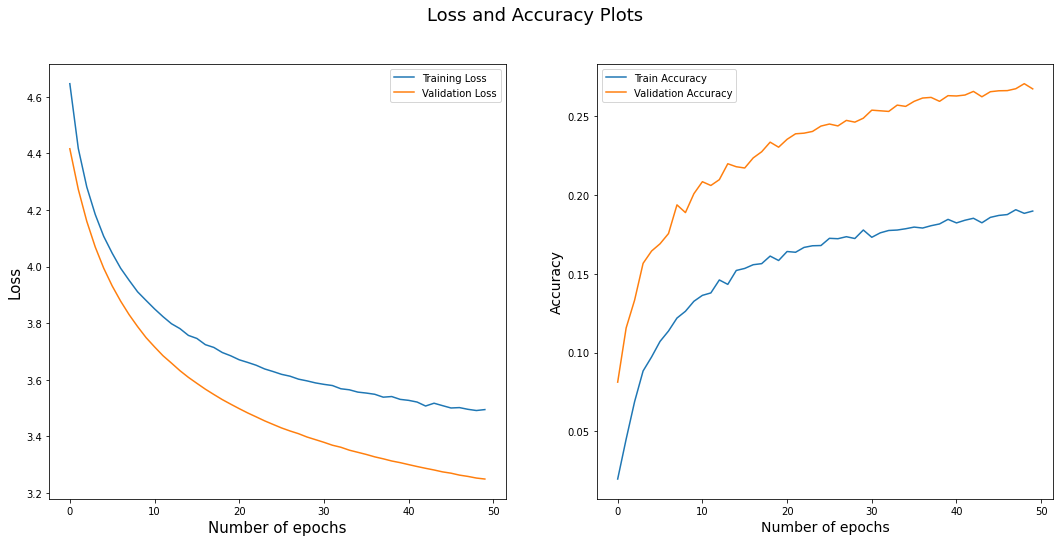

In [43]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [1]:
import tensorflow as tf
new_model = tf.keras.models.load_model('cifar_vgg16_model.h5')
# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     